In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
import itertools
import networkx as nx

from ising_model import ising
from messages import messages
from beliefs import beliefs

In [5]:
def run_temperature(N, T_list, graph_type, wmat,
                    pos = None, lattice = False):
    ising_list = []
    ising_list.append(ising(N, graph_type, wmat))  
    
    m = []
    two_cumulant = []
    
    error_max = 1e-10

    for T in T_list:
        msg = messages(ising_list[-1], T = T)
        
        error = msg.update_msg(ising_list[-1])
        while error > error_max:
            error = msg.update_msg(ising_list[-1])
        
        bel = beliefs(msg, ising_list[-1])
        bel.ev_site_bel()
        bel.ev_pair_bel(msg, ising_list[-1])
        
        ising_list[-1].update_state(bel)
        ising_list[-1].cumulants(bel)
        ising_list[-1].draw(pos, lattice)
        
        m.append(np.mean(np.array(bel.graph.nodes.data('magnetization'))[:,1]))
        
        s12 = np.array(list(ising_list[-1].graph.edges.data('two_cumulant')))[:,2]
        two_cumulant.append(np.mean(s12))
        
        print("Temperature: " + "%.2f" % T + ", magnetization: " + "%.2f" % m[-1])
    
    plt.scatter(T_list, m)
    plt.xlabel('T')
    plt.ylabel('m')
    plt.show()
    
    return ising_list, two_cumulant, m

**Fully connected (here the Bethe approximation is exact).**

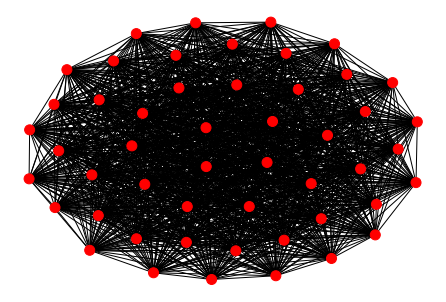

Temperature: 0.10, magnetization: 1.00


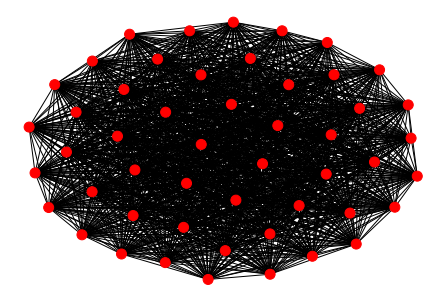

Temperature: 0.30, magnetization: 1.00


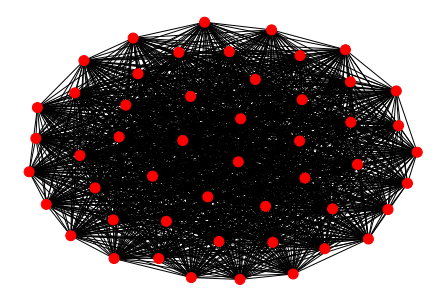

Temperature: 0.50, magnetization: 0.95


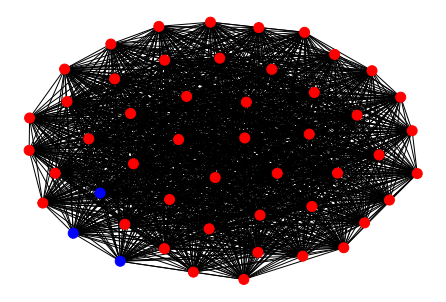

Temperature: 0.70, magnetization: 0.81


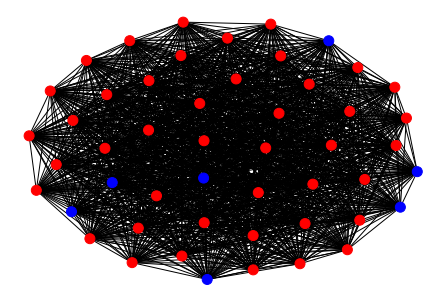

Temperature: 0.80, magnetization: 0.67


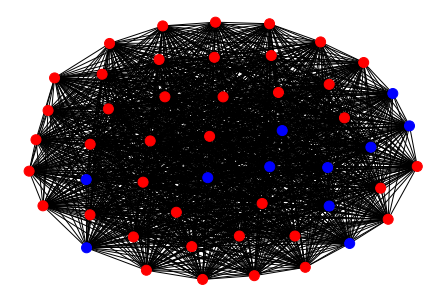

Temperature: 0.85, magnetization: 0.57


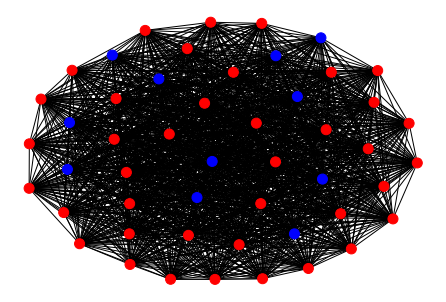

Temperature: 0.90, magnetization: 0.43


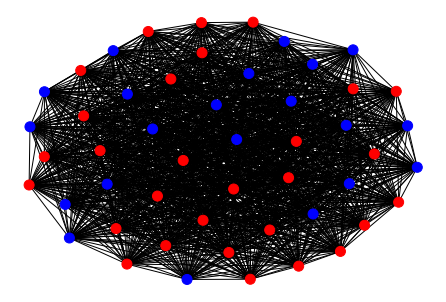

Temperature: 0.95, magnetization: 0.21


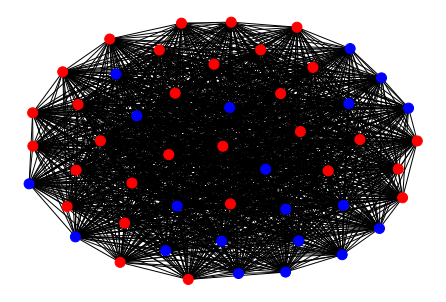

Temperature: 0.97, magnetization: 0.08


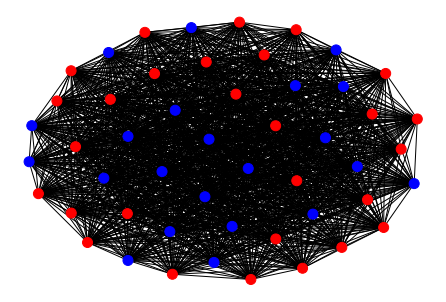

Temperature: 0.99, magnetization: 0.03


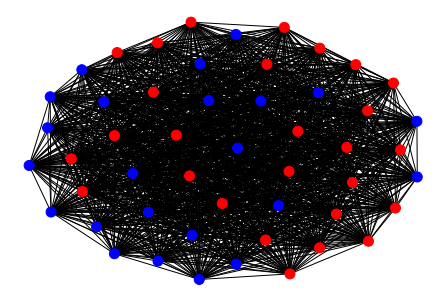

Temperature: 1.00, magnetization: 0.02


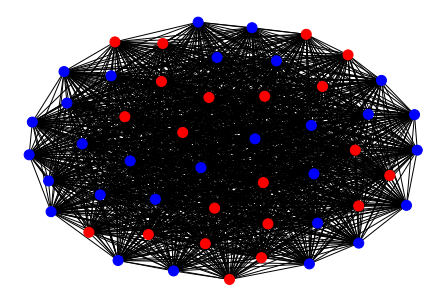

Temperature: 1.01, magnetization: 0.02


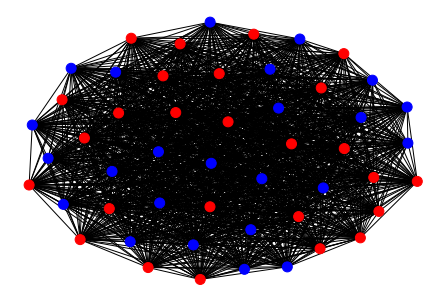

Temperature: 1.03, magnetization: 0.01


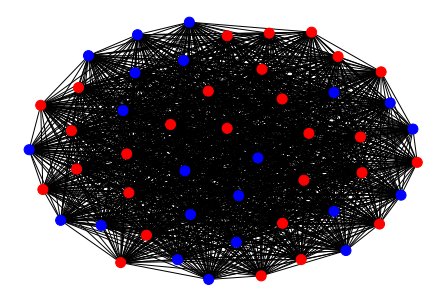

Temperature: 1.05, magnetization: 0.01


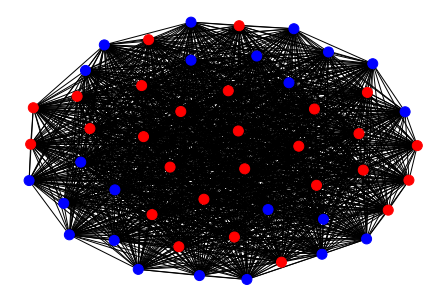

Temperature: 1.10, magnetization: 0.01


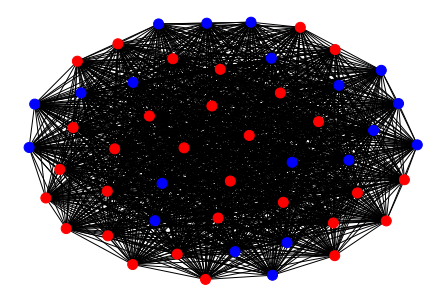

Temperature: 1.20, magnetization: 0.00


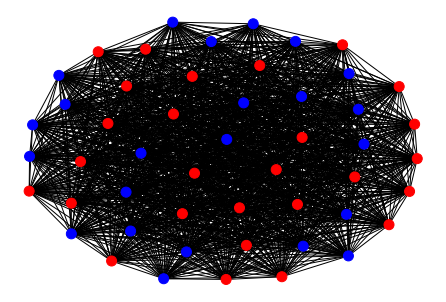

Temperature: 1.40, magnetization: 0.00


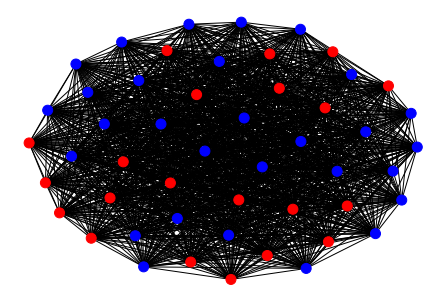

Temperature: 1.60, magnetization: 0.00


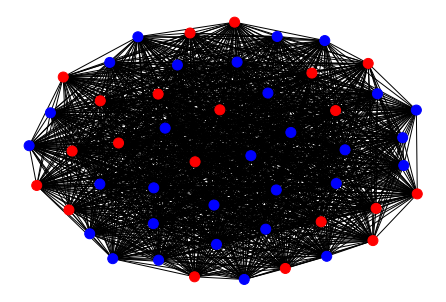

Temperature: 1.80, magnetization: 0.00


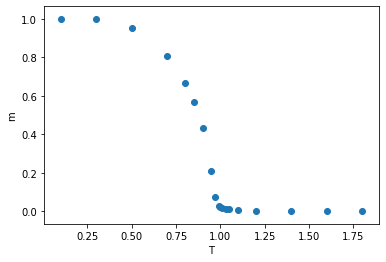

In [307]:
T_list = [0.1, 0.3, 0.5, 0.7, 0.8, 0.85, 0.90, 0.95,
          0.97, 0.99, 1, 1.01, 1.03, 1.05,
          1.1, 1.2, 1.4, 1.6, 1.8]
N = 50
wmat = np.ones((N,N))
np.fill_diagonal(wmat, 0)
wmat /= N

fully_connected = nx.complete_graph(N)

ising_list, two_cumulant, m = run_temperature(N, T_list, fully_connected, wmat)

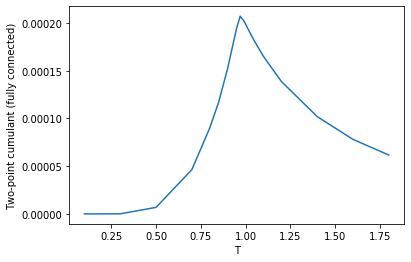

In [308]:
plt.plot(T_list, -np.array(two_cumulant))
plt.ylabel('Two-point cumulant (fully connected)')
plt.xlabel('T')
plt.show()

**2D with periodic boundary conditions (the Bethe critical point is around 2.88).**

In [10]:
class lattice_2d_pbc:
    
    def __init__(self, L):
        self.L = L
        
        self.net = nx.Graph()
        self.net.add_nodes_from(np.arange(0, self.L*self.L, 1))
        
        for i in self.net.nodes:
            site = self.linear_to_lattice(i)
            nnlist = self.find_nn(site)
            
            for j, nn_site in enumerate(nnlist):
                nnlist[j] = (i, self.lattice_to_linear(nn_site))
                
            self.net.add_edges_from(nnlist)
            
        self.pos = dict((i, tuple(self.linear_to_lattice(i))) for i in self.net.nodes())
        
        
    def lattice_to_linear(self, site):
        return site[0]*self.L + site[1]

    def linear_to_lattice(self, node):
        return np.array([int(node/self.L), node%self.L])

    def find_nn(self, site):
        moves_list = [np.array([-1,0]), np.array([0,1]),
                      np.array([1,0]), np.array([0,-1])]
        
        nn = np.array(site) + moves_list
        
        return list(nn%self.L)
    
    def draw(self):
        nx.draw(self.net, pos = self.pos)

In [19]:
T_list = [1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.6, 2.7,
          2.75, 2.8, 2.82, 2.85, 2.87, 2.88, 2.89,
          2.9, 2.95, 3, 3.1, 3.3]
L = 50
N = L*L

wmat = np.ones((N,N))
np.fill_diagonal(wmat, 0)

lattice2d = lattice_2d_pbc(L)
pos = lattice2d.pos

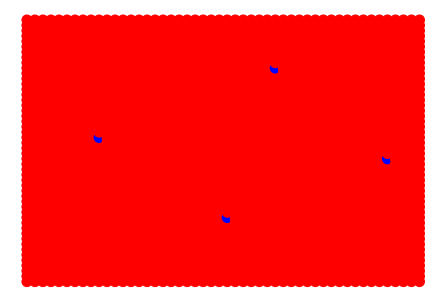

Temperature: 1.30, magnetization: 0.99


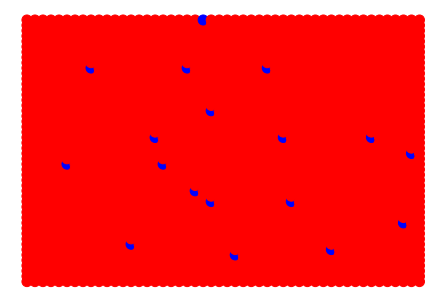

Temperature: 1.50, magnetization: 0.99


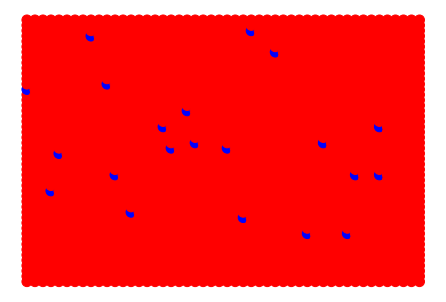

Temperature: 1.70, magnetization: 0.97


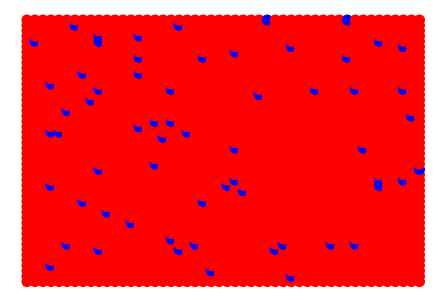

Temperature: 1.90, magnetization: 0.95


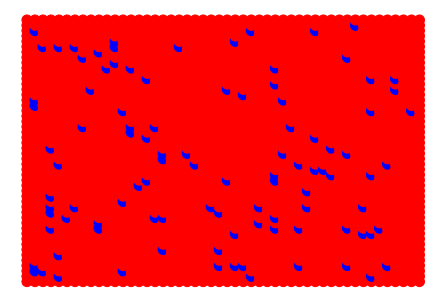

Temperature: 2.10, magnetization: 0.91


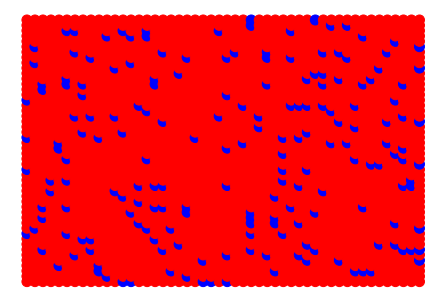

Temperature: 2.30, magnetization: 0.84


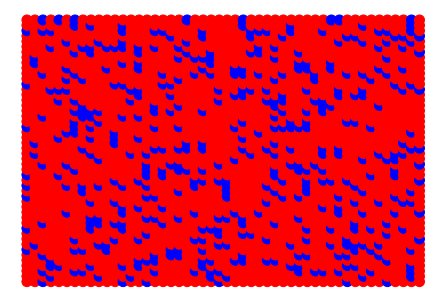

Temperature: 2.60, magnetization: 0.66


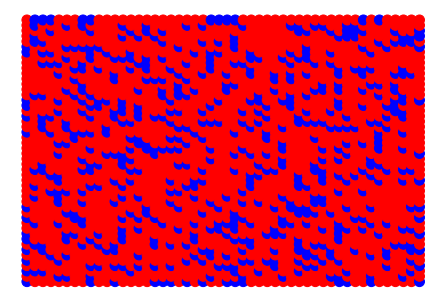

Temperature: 2.70, magnetization: 0.55


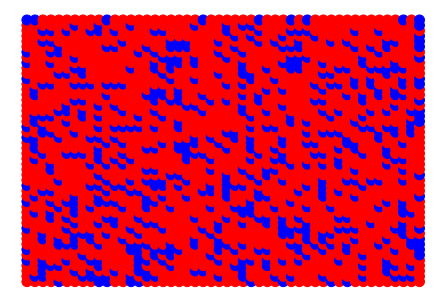

Temperature: 2.75, magnetization: 0.48


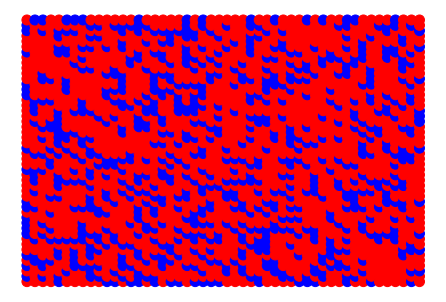

Temperature: 2.80, magnetization: 0.39


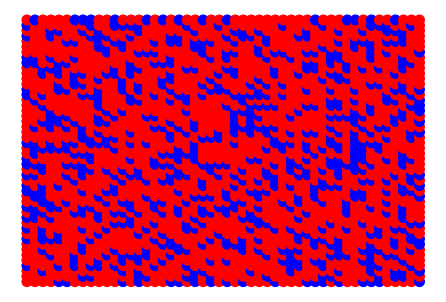

Temperature: 2.82, magnetization: 0.35


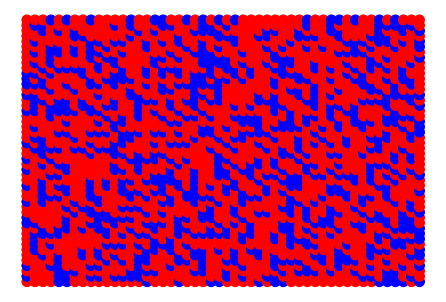

Temperature: 2.85, magnetization: 0.26


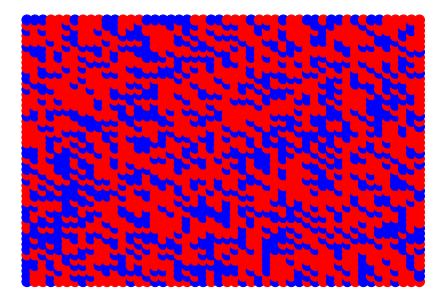

Temperature: 2.87, magnetization: 0.18


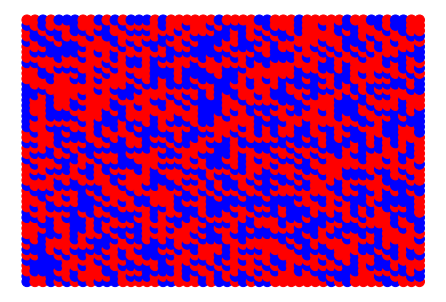

Temperature: 2.88, magnetization: 0.12


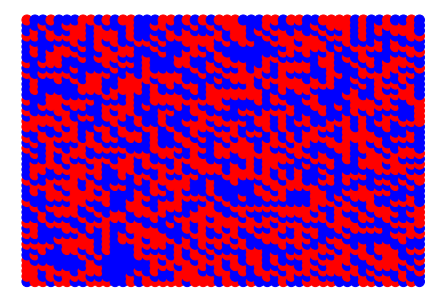

Temperature: 2.89, magnetization: 0.04


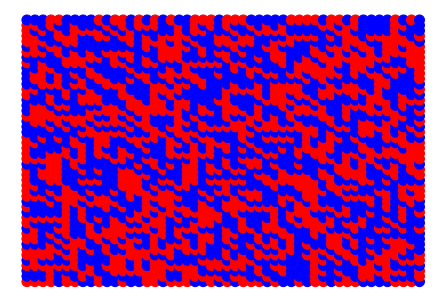

Temperature: 2.90, magnetization: 0.02


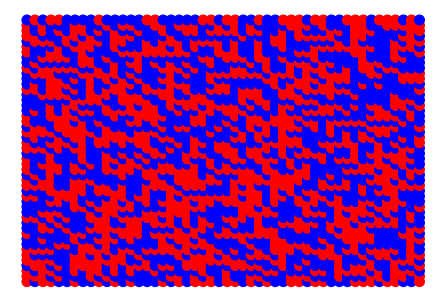

Temperature: 2.95, magnetization: 0.00


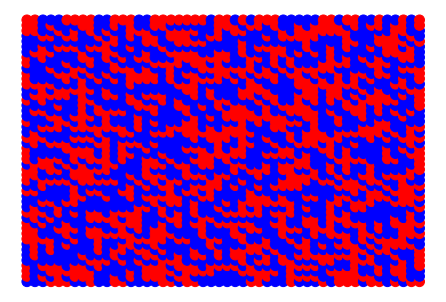

Temperature: 3.00, magnetization: 0.00


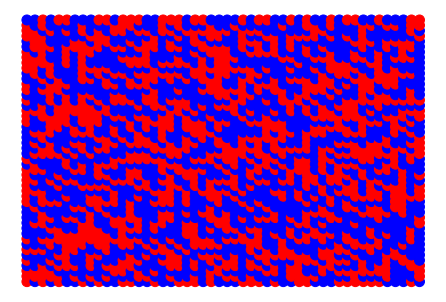

Temperature: 3.10, magnetization: 0.00


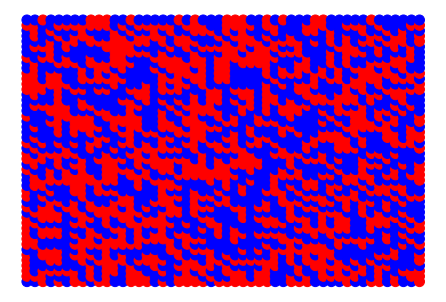

Temperature: 3.30, magnetization: 0.00


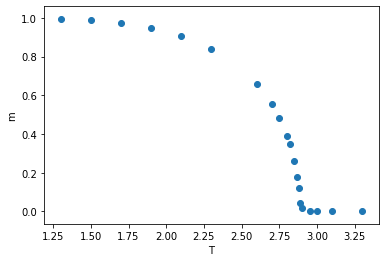

In [20]:
ising_list_2d, two_cumulant_2d, m_2d = run_temperature(N, T_list, lattice2d.net, wmat,
                                                       pos = pos, lattice = True)

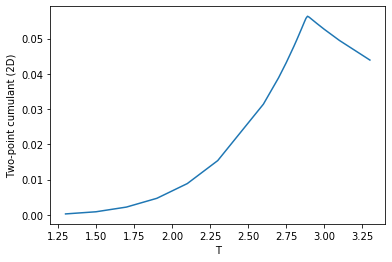

In [21]:
plt.plot(T_list, -np.array(two_cumulant_2d))
plt.ylabel('Two-point cumulant (2D)')
plt.xlabel('T')
plt.show()

**Small world graph.**

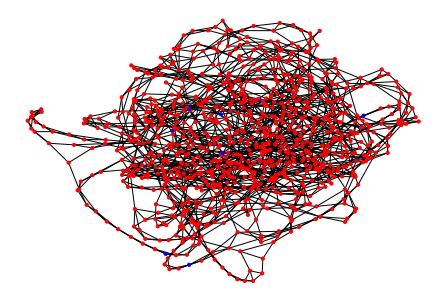

Temperature: 1.50, magnetization: 0.98


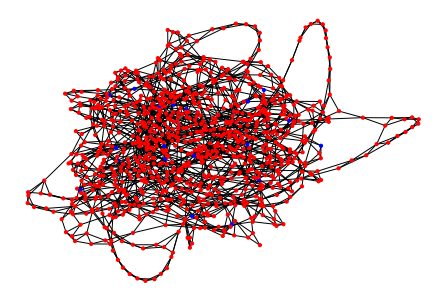

Temperature: 1.78, magnetization: 0.96


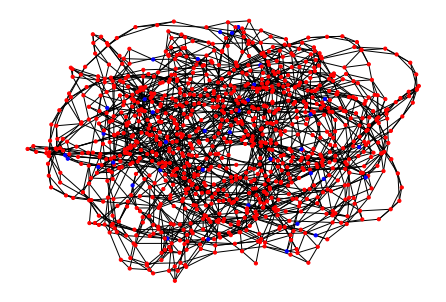

Temperature: 2.06, magnetization: 0.91


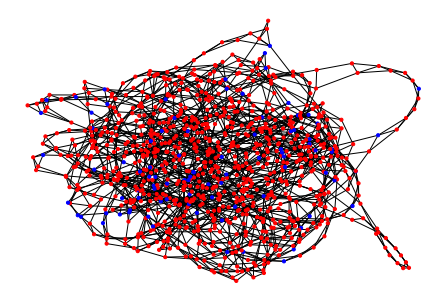

Temperature: 2.33, magnetization: 0.82


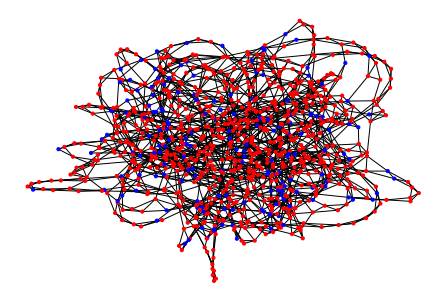

Temperature: 2.61, magnetization: 0.66


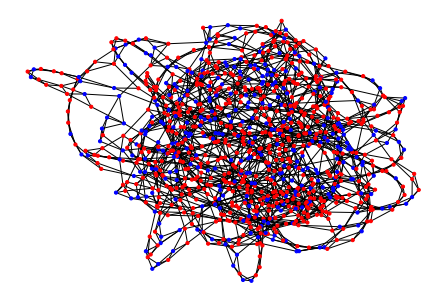

Temperature: 2.89, magnetization: 0.36


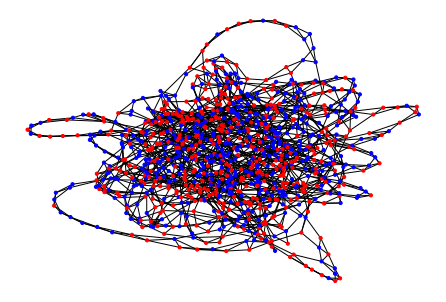

Temperature: 3.17, magnetization: 0.00


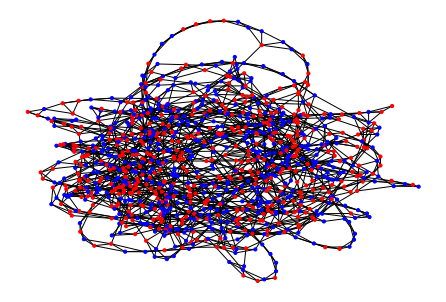

Temperature: 3.44, magnetization: 0.00


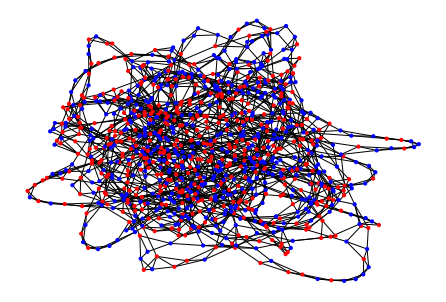

Temperature: 3.72, magnetization: 0.00


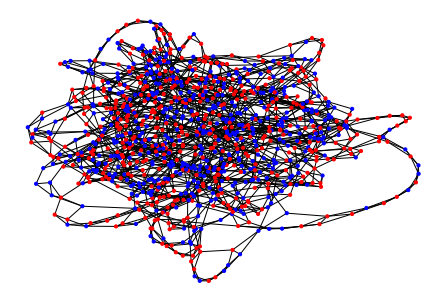

Temperature: 4.00, magnetization: 0.00


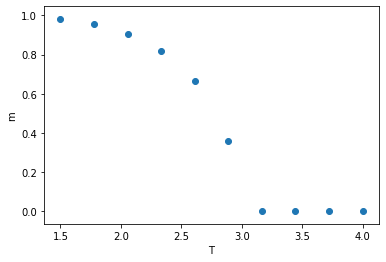

In [10]:
T_list = np.linspace(1.5,4,10)

N = 1000
wmat = np.ones((N,N))
np.fill_diagonal(wmat, 0)
graph_sw = nx.connected_watts_strogatz_graph(N, k = 4, p = 0.1)


ising_list_sf, two_cumulant_sf, m_sf = run_temperature(N, T_list, graph_sw, wmat)

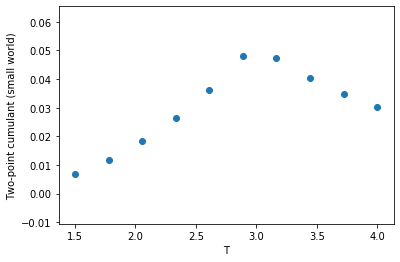

In [12]:
plt.scatter(T_list, -np.array(two_cumulant_sf))
plt.ylabel('Two-point cumulant (small world)')
plt.xlabel('T')
plt.show()